In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import scipy.optimize as opt
import scipy.integrate as integrate
import math
from math import e

incomes = np.loadtxt('usincmoms.txt')
incomes[:,1] = incomes[:,1] / 1000
pcts = incomes[:,0]
moments = incomes[:,1]

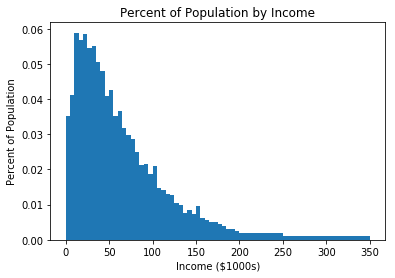

In [2]:
#Problem 1 Part a
def graph_1_a(pcts):
    incomes_graph = np.copy(pcts)
    incomes_graph[40] = incomes_graph[40]/10
    incomes_graph[41] = incomes_graph[41]/20
    width = 5 * np.ones(42)
    width[40] = 50
    width[41] = 100
    plt.bar(x=moments, height=incomes_graph, width=width)
    plt.title("Percent of Population by Income")
    plt.xlabel("Income ($1000s)")
    plt.ylabel("Percent of Population")
graph_1_a(pcts)

mu_GMM_b= -5692.298052944217  sig_GMM_b= 163.25866940396764
      fun: 0.9632528973804404
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([0., 0.])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 93
      nit: 8
   status: 0
  success: True
        x: array([-5692.29805294,   163.2586694 ])


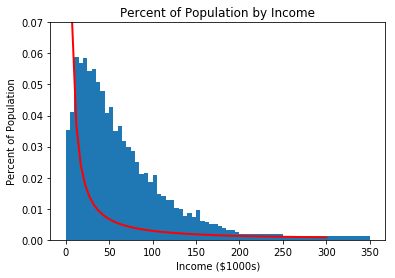

In [3]:
#Problem 1 Part b
#Problem 1 Part b - Define Functions
def ln_fun_pdf(xvals, mu, sigma):
    pdf_vals = e ** ( - (np.log(xvals) - mu) ** 2 / (2 * sigma ** 2) ) /\
            (xvals * sigma * (2 * math.pi) ** 0.5)
    return pdf_vals

def get_dist_pts():
    dist_pts = np.ones(43)
    dist_pts_beginning = np.linspace(0,200,41)
    dist_pts[0:41] = dist_pts_beginning
    dist_pts[0] = 1e-10
    dist_pts[41] = 250
    dist_pts[42] = 350
    return dist_pts

def moments_model(param_1, param_2, pdf):
    dist_pts = get_dist_pts()
    integrals = []

    prob_notcut = integrate.quad(pdf, 1e-10, 350,\
                                args=(param_1, param_2))[0]
    if prob_notcut == 0:
        return [0] * 42
    for i in range(len(dist_pts) - 1):
        vals = integrate.quad(pdf, dist_pts[i],\
                                dist_pts[i + 1],\
                                args=(param_1, param_2))[0]
        integrals.append(vals / prob_notcut)
    return np.array(integrals)

def err_vec_1(xvals, param_1, param_2, pdf, simple):
    moms_data = xvals[:,1]
    moms_model = moments_model(param_1, param_2, pdf)
    if simple:
        err_vector = moms_data - moms_model
    else:
        err_vector = (moms_model - moms_data) / moms_data
    return err_vector

def crit_1(params, *args):
    param_1, param_2 = params
    xvals, W, pdf = args
    err = err_vec_1(xvals, param_1, param_2, pdf, simple=False)
    crit_val = err.T @ W @ err
    return crit_val

def log_avg_income(incomes):
    income = incomes[:,0] * incomes[:,1]
    avg_inc = income.sum()
    return np.log(avg_inc)
#%%
#Problem 1 Part b - Define Values
mu_init = log_avg_income(incomes)
sig_init = 192
params_init = np.array([mu_init, sig_init])
W_hat = np.eye(42)
W_hat = W_hat * incomes[:,0]
gmm_args = (incomes, W_hat, ln_fun_pdf)
#%%
#Problem 1 Part b - Call Functions
results_b = opt.minimize(crit_1, params_init, args=(gmm_args), tol=1e-20,
                       method='L-BFGS-B', bounds=((None, None), (1e-10, None)))
mu_GMM_b, sig_GMM_b = results_b.x
#%%
#Problem 1 Part b - Output Results
print('mu_GMM_b=', mu_GMM_b, ' sig_GMM_b=', sig_GMM_b)
print(results_b)
#%%
#Problem 1 Part b - Print Graphs
vals_b = moments_model(mu_GMM_b, sig_GMM_b, ln_fun_pdf)
vals_b[40] = vals_b[40]/10
vals_b[41] = vals_b[41]/20

plt.plot(moments, vals_b,\
        linewidth=2, label="Log Normal Function", color="r")
graph_1_a(pcts)
plt.ylim([0, 0.07])
plt.show()

alpha_GMM_c= 1.0000000814647477e-10  beta_GMM_c= 20000.0
      fun: 0.9753869701209792
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([408931.71727828,      0.        ])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 75
      nit: 3
   status: 0
  success: True
        x: array([1.00000008e-10, 2.00000000e+04])


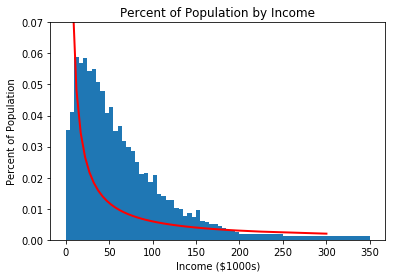

In [4]:
#Problem 1 Part c
#Problem 1 Part c - Define Functions
def gamma_fun_pdf(xvals, alpha, beta):
        pdf_vals = ( (xvals / beta) ** alpha * e ** ( - xvals / beta ) )/\
                   ( xvals * math.gamma(alpha) )
        return pdf_vals
#%%
#Problem 1 Part c - Define Values
income = incomes[:,0] * incomes[:,1]
avg_inc = income.sum()
alpha_init = 3
beta_init = 20000
params_init = np.array([alpha_init, beta_init])
W_hat = np.eye(42)
W_hat = W_hat * incomes[:,0]
gmm_args = (incomes, W_hat, gamma_fun_pdf)
#%%
#Problem 1 Part c - Call Functions
results_c = opt.minimize(crit_1, params_init, args=(gmm_args), tol=1e-20,
                        method='L-BFGS-B',\
                        bounds=((1e-10, None), (1e-10, None)))
alpha_GMM_c, beta_GMM_c = results_c.x
#%%
#Problem 1 Part c - Output Results
print('alpha_GMM_c=', alpha_GMM_c, ' beta_GMM_c=', beta_GMM_c)
print(results_c)
#%%
#Problem 1 Part c - Print Graphs
vals_c = moments_model(alpha_GMM_c, beta_GMM_c, gamma_fun_pdf)
vals_c[40] = vals_c[40]/10
vals_c[41] = vals_c[41]/20

plt.plot(moments[1:], vals_c[1:],\
        linewidth=2, label="Gamma Function", color="r")
graph_1_a(pcts)
plt.ylim([0, 0.07])
plt.show()

Log Normal results:
      fun: 0.9632528973804404
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([0., 0.])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 93
      nit: 8
   status: 0
  success: True
        x: array([-5692.29805294,   163.2586694 ])
Gamma Results:
      fun: 0.9753869701209792
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([408931.71727828,      0.        ])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 75
      nit: 3
   status: 0
  success: True
        x: array([1.00000008e-10, 2.00000000e+04])


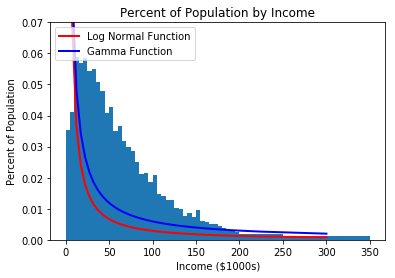

In [5]:
#Problem 1 Part d
#Problem 1 Part d - Print Graphs
plt.plot(moments, vals_b,\
        linewidth=2, label="Log Normal Function", color="r")
plt.plot(moments[1:], vals_c[1:],\
        linewidth=2, label="Gamma Function", color="b")
graph_1_a(pcts)
plt.legend(loc="upper left")
plt.ylim([0, 0.07])
#%%
#Problem 1 Part d - Answer Question
print("Log Normal results:")
print(results_b)
print("Gamma Results:")
print(results_c)